In [1]:
import pandas as pd
import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
import sys

In [4]:
release_dir = "/kwiat/vector/ag1000g/release/phase2.AR1"

In [5]:
meta_fn = os.path.join(release_dir, "samples/samples.meta.txt")

In [6]:
meta = pd.read_table(meta_fn)

In [7]:
ibd_fn = "/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/{chrom}/{pop}.ibd"

In [8]:
meta.population.value_counts()

CMgam    297
UGgam    112
BFgam     92
GW        91
AOcol     78
BFcol     75
CIcol     71
GAgam     69
GM        65
GHcol     55
KE        48
GNgam     40
FRgam     24
GHgam     12
GQgam      9
GNcol      4
Name: population, dtype: int64

In [9]:
populations = meta.population.unique()
populations

array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'UGgam', 'GM', 'GW', 'KE',
       'CMgam', 'FRgam', 'GQgam', 'AOcol', 'GAgam', 'GNgam', 'GNcol',
       'CIcol'], dtype=object)

In [10]:
import collections
IBDCOLS = ["sample1", "i1", "sample2", "i2", "chrom", "start", "end", "LOD"]

def get_IBD(chrom, pop, cutoff=100000):
    
    
    
    if not isinstance(chrom, str):
        f = {c: get_IBD(c, pop, cutoff) for c in chrom}
        f = pd.concat(f).groupby(level=[1, 2]).aggregate(sum)
        
    else:
        
        ibddf = pd.read_table(
            ibd_fn.format(chrom=chrom, pop=pop), 
            names=IBDCOLS)

        ibddf["tot_len"] = ibddf.end - ibddf.start
        ibddf = ibddf.loc[ibddf.tot_len >= cutoff]

        from itertools import combinations

        samples = sorted(meta.query("population == @pop").ox_code)
        all_combs = list(combinations(samples, 2))

        len(all_combs)

        ibddf = ibddf.set_index(["sample1", "sample2"])

        g = ibddf.groupby(level=[0, 1])
        ibd_sum = g.tot_len.aggregate(np.sum)
        ibd_count = g.tot_len.count()
        
        # vindex is all possible combinations
        vindex = pd.MultiIndex.from_tuples(all_combs, names=["Sample1", "Sample2"])

        f = pd.concat([ibd_sum, ibd_count], axis=1).reindex(index=vindex, fill_value=0)
        f.columns = ["IBDsum", "IBDcount"]
    
    return f

In [11]:
seq_ids = ("2R", "2L", "3R", "3L")

In [12]:
ibd_dict = {pop: get_IBD(seq_ids, pop, 10000) for pop in populations}

In [13]:
all_pop_sum = pd.concat(ibd_dict, names=["population"])
all_pop_sum.max(0)

IBDsum      205688606.0
IBDcount          139.0
dtype: float64

In [14]:
a, b = all_pop_sum.idxmax(0)

In [15]:
all_pop_sum.loc[a]

IBDsum      205688606.0
IBDcount            4.0
Name: (CMgam, AN0144-C, AN0205-C), dtype: float64

In [16]:
all_pop_sum.sort_values("IBDsum", ascending=False).head(10)

IBDsum  IBDcount
population Sample1  Sample2                        
CMgam      AN0144-C AN0205-C  205688606.0         4
           AN0164-C AN0201-C  205301298.0         4
           AN0020-C AN0169-C  205266070.0         4
           AN0085-C AN0107-C  204754141.0         6
           AN0154-C AN0193-C  204554682.0         5
           AN0144-C AN0174-C  203238232.0         6
           AN0020-C AN0142-C  188306436.0         8
           AN0223-C AN0259-C  184578764.0        15
           AN0191-C AN0207-C  183062062.0         8
GHcol      AA0110-C AA0140-C  173939421.0         7

In [17]:
# Triple of 144, 174 and 205 doesn't match...
all_pop_sum.loc[("CMgam", "AN0144-C", "AN0174-C")]

IBDsum      203238232.0
IBDcount            6.0
Name: (CMgam, AN0144-C, AN0174-C), dtype: float64

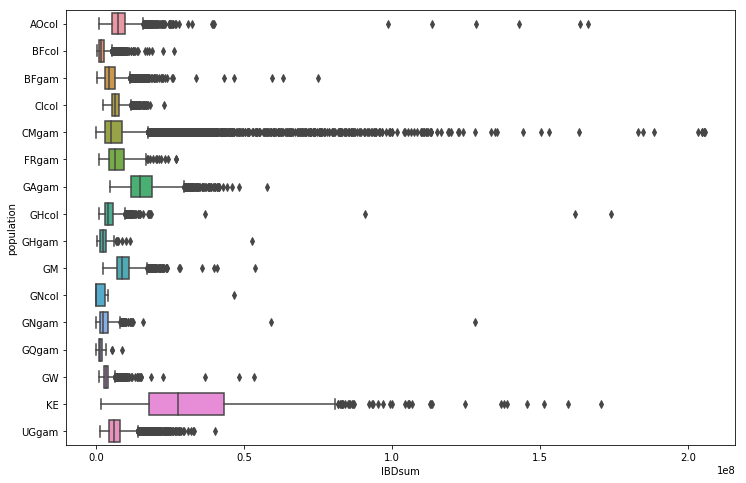

In [18]:
f = plt.figure(figsize=(12, 8))
sns.boxplot(x="IBDsum", y="population", data=all_pop_sum.reset_index())

In [19]:
# samples with most ibd
meta.set_index("ox_code").loc[list(a[1:])]

,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage
ox_code,,,,,,,,,,,
AN0144-C,CM0901594,CMgam,Cameroon,Mayos,Nora Besansky,Reidenbach,2009.0,S,F,174339000,58.8
AN0205-C,CM0901581,CMgam,Cameroon,Mayos,Nora Besansky,Reidenbach,2009.0,S,F,55923006,16.7


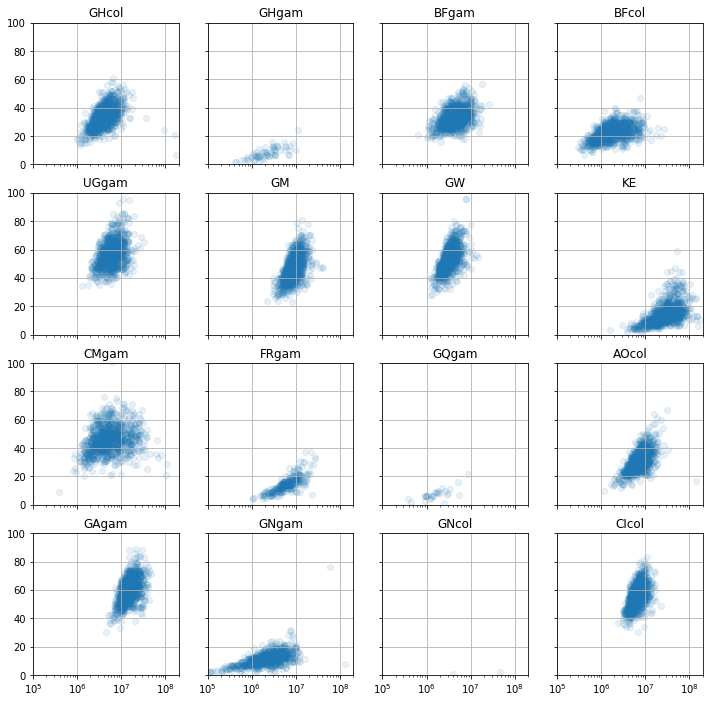

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ix, pop in enumerate(populations):
    
    i = (ix // 4)
    j = (ix % 4)
    
    ax = axes[i, j]
    
    ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
    
    ax.scatter(ibd.IBDsum, ibd.IBDcount, alpha=0.1)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlim((10**5, 2 * 10**8))
    ax.set_ylim((0, 100))
    ax.set_title(pop)
    ax.grid(True)
    if i < 3:
        ax.set_xticklabels([])
    if j > 0:
        ax.set_yticklabels([])